In [369]:
import numpy as np
import cv2
from debayer.superpixel import debayer_superpixel
from astropy.io import fits
from fwhm.star_matcher import StarMatcher
from fwhm.star_finder import StarFinder
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import ICRS
from skymap.skymap import SkyMap
from skymap.stardb.render_view import project
import matplotlib.pyplot as plt
from pathlib import Path


|    | Initial     |    Corrected |
| --- | ---- | --- |
| Albereo |
| RA  | 19h31m39.9612s  | 19h30m52.1928s |
| Dec | 28d00m47.8116s  | 28d02m10.5612 |
| RA  | 19h30m43.2072s  | 19h30m40.8528s |
| Dec | 27d57m35.4204s  | 28d00m37.9908s |
| NGC 7000 |
| RA  | 20h58m46.9452s  | 20h58m50.6532s |
| Dec  | 44d19m48.0612s  | 44d12m19.0872s |
| Crescent Nebula |
| RA  | 20h12m57.7404s  | 20h13m01.7652s |
| Dec | 38d25m36.714s  |  38d30m20.232s |
| Deneb |
| RA  | 20h41m27.2616s  | |
| Dec | 45d16m38.3736s  | |

In [370]:
targets = {
  "Albereo": {
    "location": SkyCoord("19h31m39.9612s", "28d00m47.8116s", frame=ICRS),
    "dir": r"D:\Astro\plate-solving-samples\Albereo\Light"
  },
  "NGC 7000": {
    "location": SkyCoord("20h58m46.9452s", "44d19m48.0612s", frame=ICRS),
    "dir": r"D:\Astro\plate-solving-samples\NGC7000\Light"
  },
  "Crescent Nebula": {
    "location": SkyCoord("20h12m57.7404s", "38d25m36.714s", frame=ICRS),
    "dir": r"D:\Astro\plate-solving-samples\NGC6888\Light"
  },
  "Deneb": {
    "location": SkyCoord("20h41m27.2616s", "45d16m38.3736s", frame=ICRS),
    "dir": r"D:\Astro\plate-solving-samples\Deneb\Light"
  },
  "Alpheratz": {
    "location": SkyCoord("00h08m23.25988s", "+29d05m25.5520s", frame=ICRS),
    "dir": r"D:\Astro\plate-solving-samples\Alpheratz\Light"
  }
}

In [371]:
center = targets["Albereo"]["location"]
fname = r'D:/Astro/plate-solving-samples/Albereo/Light/Light_03253_10.0sec_120gain_20.4C.fit'
print(center, fname)

<SkyCoord (ICRS): (ra, dec) in deg
    (292.916505, 28.013281)> D:/Astro/plate-solving-samples/Albereo/Light/Light_03253_10.0sec_120gain_20.4C.fit


In [372]:
# # M101 - EDT115:
# center, fname = SkyCoord(14.066564 * u.hour, 54.218594 * u.degree, frame=ICRS), r"D:\Astro\20230319-M81M82_M101_M13\Light-M101-300sec\Light_ASIImg_300sec_Bin1_-9.4C_gain200_2023-03-20_023749_frame0026.fit"

# # M101 - C11:
# # center, fname = SkyCoord(14.066564 * u.hour, 54.218594 * u.degree, frame=ICRS), r"D:\Astro\20230528-M101-Supernova\20230601\M101\Light\Light_02780_180.0sec_300gain_0.0C.fit"
# # center, fname = SkyCoord(14.066564 * u.hour, 54.218594 * u.degree, frame=ICRS), r"D:\Astro\20230528-M101-Supernova\M101\Light\Light_02650_180.0sec_300gain_-0.3C.fit"
# # center, fname = SkyCoord(14.066564 * u.hour, 54.218594 * u.degree, frame=ICRS), r"D:\Astro\20230528-M101-Supernova\M101\Light\Light_02693_180.0sec_300gain_0.0C.fit"

# # Bubble Nebula - EDT115:
# #center, fname = SkyCoord("23h20m48.3s" "+61d12m06s", frame=ICRS), r"D:\Astro\20230818-uacnj\Bubble\Light\Light_03128_180.0sec_200gain_0.0C.fit"




## Cone search given object sky-coord

In [373]:
import itertools

def cone_search_stardata(skymap: SkyMap, center: SkyCoord, fov_deg: float):
  stars = []
  for star in skymap.coneSearch(center, fov_deg):
    if 'mag' in star and star['mag'] < 11:
      s_coord = SkyCoord(star['ra'] * u.degree, star['dec'] * u.degree, frame=ICRS)
      x, y = project(s_coord.ra.degree, s_coord.dec.degree, center.ra.degree, center.dec.degree, 0)
      stars.append({
        "id": star["_id"], 
        "cluster_cx": x, "cluster_cy": y, 
        "ra": s_coord.ra.degree, "dec": s_coord.dec.degree,
        "mag": star["mag"]
      })
  df_ref = pd.DataFrame(stars)
  return df_ref

with SkyMap() as sm:
  df_ref = cone_search_stardata(sm, center, fov_deg=5.0)

## Plot of stars in the neighborhood

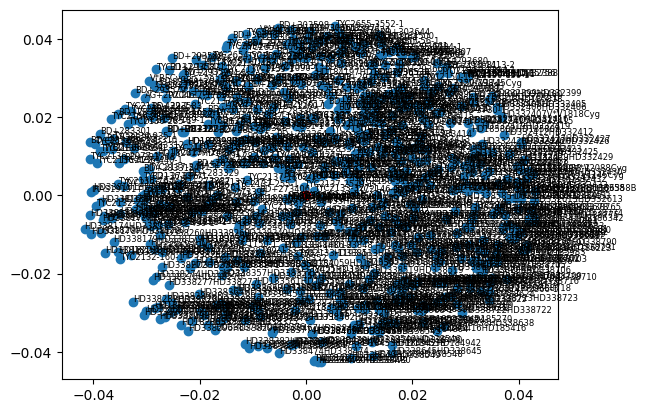

In [374]:
plt.scatter(df_ref.cluster_cx, df_ref.cluster_cy)
for i in range(len(df_ref)):
  r = df_ref.iloc[i]
  plt.annotate(r.id, (r.cluster_cx, r.cluster_cy), fontsize=6)
x, y = project(center.ra.degree, center.dec.degree, center.ra.degree, center.dec.degree, 0)
plt.scatter([x], [y], c='r')

plt.show()

In [375]:
df_ref.head()

,id,cluster_cx,cluster_cy,ra,dec,mag
0,NAMEAlbereoNAMEAlbireo*bet01Cyg,-0.003641,-0.000932,292.680336,27.959680,3.156923
1,HD183912*bet01CygA,-0.003640,-0.000932,292.680358,27.959678,3.736250
2,HD182568*2Cyg,-0.028594,0.028283,291.031577,29.621336,4.844222
3,HD183914*bet02Cyg,-0.003505,-0.000835,292.689151,27.965275,5.030000
4,HD183913*bet01CygB,-0.003640,-0.000933,292.680396,27.959617,5.193750


## Read image and run star matching

In [376]:

with fits.open(fname) as f:
    ph = f[0]
    img = ph.data
    img = np.expand_dims(img, axis=2)
    # img16 = debayer_superpixel(img)
    img16 = cv2.cvtColor(img, cv2.COLOR_BAYER_BG2BGR) # RGGB pattern

assert(img16.dtype == np.uint16)
assert(len(img16.shape) == 3)
assert(img16.shape[2] == 3)
img16 = cv2.cvtColor(img16, cv2.COLOR_BGR2GRAY)
img8 = ((img16 / np.iinfo(np.uint16).max) *np.iinfo(np.uint8).max).astype(np.uint8)
numStars = 20
# img8 = cv2.equalizeHist(img8)
star_img, df_tgt = StarFinder().find_stars(img8=np.squeeze(img8), img16=np.squeeze(img16), topk=numStars)

# votes, vVotingPairs = StarMatcher().matchStars(df_ref, df_tgt, return_merged=False)


c:\Users\anand\anaconda3\envs\astro\lib\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


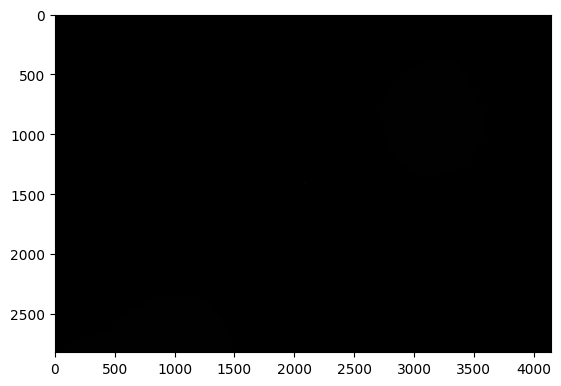

In [377]:
plt.imshow(img8, cmap='gray')

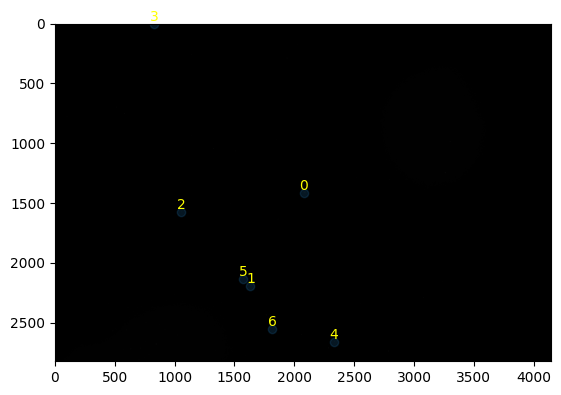

In [378]:
plt.imshow(img8, cmap='gray')
plt.scatter(df_tgt.cluster_cx, df_tgt.cluster_cy, alpha=0.2)
for idx, tgt in df_tgt.iterrows():
  plt.text(tgt.cluster_cx, tgt.cluster_cy, idx, va='bottom', ha='center', c='yellow')

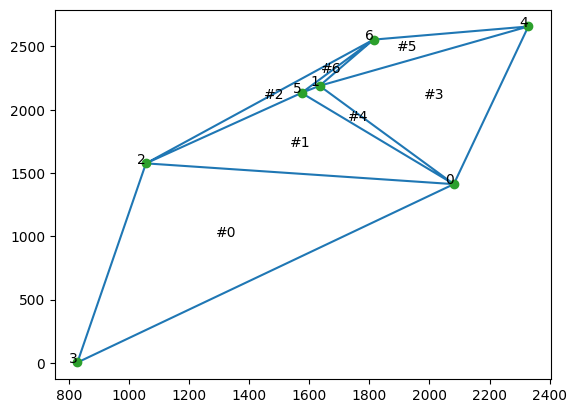

In [379]:
from scipy.spatial import Delaunay
import numpy as np
points = np.array(df_tgt.apply(lambda x: [x.cluster_cx, x.cluster_cy], axis=1).to_list())
tri = Delaunay(points)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for j, p in enumerate(points):
    plt.text(p[0]-0.03, p[1]+0.03, j, ha='right') # label the points
for j, s in enumerate(tri.simplices):
    p = points[s].mean(axis=0)
    plt.text(p[0], p[1], f'#{j}', ha='center') # label triangles

plt.show()

In [380]:
m = StarMatcher()

tri_tgt = pd.DataFrame(m._getVertexSortedTriangles(df_tgt, itertools.combinations(df_tgt.index, 3), fov_deg=None))

# tri_ref =  m._getVertexSortedDelaunayTriangles(df_ref, fov_deg=1.0)


# tri_ref = []
# for mag_lim in range(int(df_ref.mag.min())+1, int(df_ref.mag.max())+2, 1):
#   df = df_ref[df_ref.mag <= mag_lim]
#   print(mag_lim, len(df))
#   if len(df) < 3: continue
#   tri_ref.append(m._getVertexSortedDelaunayTriangles(df, fov_deg=1.0))
# tri_ref = pd.concat(tri_ref)


D = None
vTriangles = []
initial_points = []
pt_idx = []
for mag in range(int(df_ref.mag.min()), int(df_ref.mag.max())+1, 1):
  df = df_ref[(df_ref.mag >= mag) & (df_ref.mag < mag+1)]

  points = []
  for idx, r in df.iterrows():
    points.append([r.cluster_cx, r.cluster_cy])
    pt_idx.append(idx)

  if D is None:
    if len(initial_points) < 4:
      initial_points.extend(points)
    
    if len(initial_points) >= 4:
      D = Delaunay(initial_points, incremental=True)
  else:
    D.add_points(points)

    print(mag, len(df))
    if len(df) < 3: continue
    pt_indices = [[pt_idx[x], pt_idx[y], pt_idx[z]] for x,y,z in D.simplices]
    vTriangles.extend(m._getVertexSortedTriangles(df_ref, pt_indices, fov_deg=1.0))

vTriangles = sorted(vTriangles, key=lambda x: x["fX"])
tri_ref = pd.DataFrame(vTriangles)

print(f"Ref triangles: {len(tri_ref)}, Tgt triangles: {len(tri_tgt)}")

6 6
7 19
8 61
9 191
10 499
Ref triangles: 2228, Tgt triangles: 35


In [381]:
tri_ref

,A,B,C,fX,fY
0,668,438,419,0.000097,0.999930
1,668,438,597,0.000145,0.999910
2,239,311,75,0.000213,1.000000
3,311,239,467,0.000214,0.999880
4,4,0,38,0.000231,0.999866
...,...,...,...,...,...
2223,541,716,154,0.970768,0.983948
2224,301,398,396,0.978161,0.984074
2225,570,179,140,0.983673,0.984610
2226,434,468,702,0.987152,0.992885


In [382]:
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y
0,230,2080.960870,1411.969565,16.000977,15.000977,15.844343,17.157654,"[2063, 1396, 2098, 1427]",366228,5785,60.802441,68.597562
1,122,1633.639344,2188.516393,11.000977,12.000977,12.546237,11.557913,"[1622, 2176, 1645, 2201]",567100,8891,53.078723,47.538285
2,116,1055.129310,1576.017241,10.000977,10.000977,11.035679,11.168344,"[1044, 1565, 1067, 1588]",408448,6403,55.449497,54.945122
3,94,826.606383,3.425532,11.000977,2.000977,-333.531165,12.076901,"[814, 0, 839, 12]",1243,26,213.617939,28.452669
4,94,2329.276596,2657.244681,9.000977,9.000977,9.997101,9.994672,"[2319, 2647, 2340, 2668]",688486,10863,45.926763,44.612881
5,80,1573.500000,2132.500000,8.000977,10.000977,10.587776,8.386346,"[1565, 2122, 1582, 2143]",552581,8759,44.964239,35.636383
6,63,1813.444444,2553.444444,7.000977,7.000977,7.877617,7.978889,"[1805, 2545, 1822, 2562]",661421,10457,39.647387,40.148788


In [383]:
tri_tgt

,A,B,C,fX,fY
0,1,5,3,0.035283,0.968627
1,5,1,4,0.089325,0.911676
2,1,5,0,0.091708,0.983401
3,1,5,2,0.097549,0.902672
4,6,1,3,0.148783,0.851901
5,5,1,6,0.169621,0.839621
6,4,6,3,0.172532,0.896578
7,6,5,3,0.177203,0.825174
8,4,1,3,0.275048,0.763796
9,4,5,3,0.301695,0.739833


## Cluster triangles

In [384]:
#TRIANGLETOLERANCE = 1e-3

In [385]:
# ab = tri_tgt.groupby(by=['A', 'B']).agg(list)
# idx = ab.C.apply(len).argmax()
# c = ab.iloc[idx].C
# a,b = ab.index[idx]
# print(a,b,c)
# print(ab.iloc[idx])

# matches = {}
# for ci in c:
#     tgt = tri_tgt[(tri_tgt.A==a)&(tri_tgt.B==b)&(tri_tgt.C==ci)]
#     if len(tgt) > 0:
#         fX, fY = tgt.fX.iloc[0], tgt.fY.iloc[0]
#         s1 = tri_ref[
#             (tri_ref.fX >= fX - TRIANGLETOLERANCE/2) &
#             (tri_ref.fX <= fX + TRIANGLETOLERANCE/2) &
#             (tri_ref.fY >= fY - TRIANGLETOLERANCE/2) &
#             (tri_ref.fY <= fY + TRIANGLETOLERANCE/2)
#         ]
#         s1 = s1.apply(lambda r: set([int(r.A), int(r.B), int(r.C)]), axis=1)
#         if len(s1) > 0:
#             matches[(a,b,ci)] = s1.to_list()

In [386]:
# from collections import defaultdict

# candidates = set()
# match_keys = list(matches.keys())
# print(match_keys)

# for i1 in range(len(match_keys)):
#     (a1, b1, c1) = match_keys[i1]
#     for x in matches[(a1, b1, c1)]:
#         for i2 in range(i1+1, len(match_keys)):
#             (a2, b2, c2) = match_keys[i2]
#             for y in matches[(a2, b2, c2)]:
#                 ix = x.intersection(y)
#                 if len(ix) == 2:
#                     ix = sorted(list(ix))
#                     candidates.add(tuple(ix))

# candidate_counts = defaultdict(int)
# for i1 in range(len(match_keys)):
#     (a1, b1, c1) = match_keys[i1]
#     for x in matches[(a1, b1, c1)]:
#         for y in candidates:
#             ix = x.intersection(y)
#             if len(ix) == 2:
#                 print(i1, x, y)
#                 candidate_counts[y] += 1

In [387]:
# candidate_counts

In [388]:
# plt.scatter(df_ref.cluster_cx, df_ref.cluster_cy)
# for i in range(len(df_ref)):
#   r = df_ref.iloc[i]
#   plt.annotate(r.id, (r.cluster_cx, r.cluster_cy), fontsize=6)


# t = df_ref[df_ref.index.isin([155, 60, 115])]
# plt.scatter(t.cluster_cx, t.cluster_cy, c='r')

# plt.show()

## Triangle matching

In [389]:

from itertools import product

vertex_sorted = True
down_votes = True
absolute_similar = True
vote_with_conf = True


for TRIANGLETOLERANCE in [
        # 1e-5, 5e-5, 1e-4, 2e-4,
        # 3e-4, 5e-4, 7e-4, 1e-3,
        # 2e-3, 
        5e-3, 7e-3, 1e-2]:
    votes = np.zeros((len(df_ref)+1, len(df_tgt)+1), dtype=np.float32)

    for tgt in tri_tgt.itertuples():
        if absolute_similar:
            similar_triangles = tri_ref[
                (tri_ref.fX >= tgt.fX - TRIANGLETOLERANCE/2) &
                (tri_ref.fX <= tgt.fX + TRIANGLETOLERANCE/2) &
                (tri_ref.fY >= tgt.fY - TRIANGLETOLERANCE/2) &
                (tri_ref.fY <= tgt.fY + TRIANGLETOLERANCE/2)
            ]
        else:
            ref_matches = tri_ref[
                (tri_ref.fX >= tgt.fX - TRIANGLETOLERANCE/2) &
                (tri_ref.fX <= tgt.fX + TRIANGLETOLERANCE/2)]
            similar_triangles = ref_matches[(ref_matches.fX-tgt.fX)**2 + (ref_matches.fY-tgt.fY)**2 < TRIANGLETOLERANCE**2]

        for ref in similar_triangles.itertuples():
            if vote_with_conf:
                err = ((ref.fX-tgt.fX)**2 + (ref.fY-tgt.fY)**2)
                upvote = 1/(np.exp(err*100))
                downvote = upvote / 4
            else:
                upvote = 1
                downvote = 1/4

            if vertex_sorted:
                # expect matched ABC vertices
                votes[ref.A, tgt.A] += upvote
                votes[ref.B, tgt.B] += upvote
                votes[ref.C, tgt.C] += upvote

                if down_votes:
                    votes[ref.A, tgt.B] -= downvote
                    votes[ref.A, tgt.C] -= downvote

                    votes[ref.B, tgt.A] -= downvote
                    votes[ref.B, tgt.C] -= downvote
                    
                    votes[ref.C, tgt.A] -= downvote
                    votes[ref.C, tgt.B] -= downvote
            else:
                # expect unordered star indices s1, s2, s3
                for a,b in product([ref.s1, ref.s2, ref.s3], [tgt.s1, tgt.s2, tgt.s3]):
                    votes[int(a), b] += upvote
    if np.sum(votes) > 10:
        break
    
print(f"TRIANGLETOLERANCE: {TRIANGLETOLERANCE}")
print(f"Total triangle comparisons: {len(tri_ref) * len(tri_tgt)}")
print(f"Total votes: {np.sum(votes)}, hit-ratio: {np.sum(votes) / (len(tri_ref) * len(tri_tgt))}")


TRIANGLETOLERANCE: 0.007
Total triangle comparisons: 77980
Total votes: 10.489513397216797, hit-ratio: 0.0001345154321264016


In [390]:
with open('votes.csv', 'wt') as f:  
  arr = votes.flatten()
  for i in range(arr.shape[0]):
    f.write(f"{arr[i]}\n")


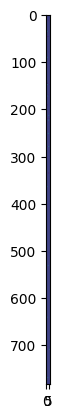

In [391]:
plt.imshow(votes)

(array([  42.,    0., 6201.,    0.,    0.,    0.,    0.,    0.,    0.,
          21.]),
 array([-0.24989291, -0.12494645,  0.        ,  0.12494645,  0.24989291,
         0.37483937,  0.49978581,  0.62473226,  0.74967873,  0.87462515,
         0.99957162]),
 <BarContainer object of 10 artists>)

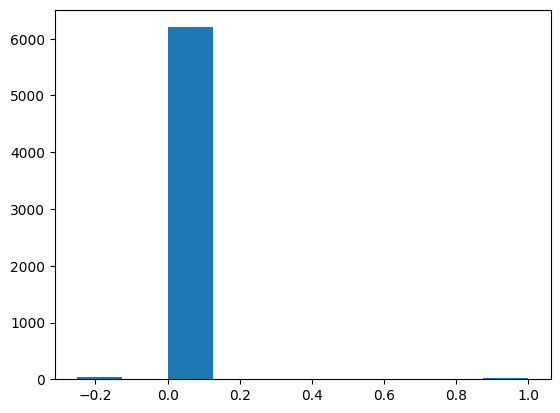

In [392]:
plt.hist(votes.flatten())

In [393]:
# Produce sorted list of star pairs with highest votes
vVotingPairs = np.column_stack(np.unravel_index(np.argsort(votes, axis=None), shape=votes.shape))[::-1]

In [394]:
cutoff = votes.max() / 4
# print(f"Vote cutoff threshold: {cutoff}")
topVotePairs = list(filter(lambda r: votes[r[0],r[1]] > cutoff, vVotingPairs))

matches = []
for vp in topVotePairs:
    s1, s2 = vp
    # if s1 == 0 or s2 == 0: # WHY ?
    #     continue
    if np.argmax(votes[:, s2]) == s1 and np.argmax(votes[s1, :]) == s2:
        matches.append((s1, s2))

df_tgt['starno'] = None
df_tgt['votes'] = None
for m1, m2 in matches:
    df_tgt.loc[m2, 'starno'] = m1
    df_tgt.loc[m2, 'votes'] = votes[m1, m2]

In [395]:
d = []
# n = []
for i in range(len(df_tgt)):
    m = votes[:,i]
    ave = (m.sum() - m.max())/(len(m)-1)
    d.append((m.max()-ave)/ave)
    # n.append(len(np.argwhere(m > 2 * ave)))
print(d)
# print(n)
# plt.plot(m)
# plt.plot(np.arange(0, len(m)), np.full(len(m), ave))


[390.3000895497378, -569652865.0, 781.7398909537604, 1565.2241839259907, 1565.0533721041209, -2306634.233990148, -1564.9999999999998]


## Matched stars

In [396]:
# display(df_tgt[~df_tgt.starno.isnull()])
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y,starno,votes
0,230,2080.960870,1411.969565,16.000977,15.000977,15.844343,17.157654,"[2063, 1396, 2098, 1427]",366228,5785,60.802441,68.597562,146,0.999572
1,122,1633.639344,2188.516393,11.000977,12.000977,12.546237,11.557913,"[1622, 2176, 1645, 2201]",567100,8891,53.078723,47.538285,171,0.998646
2,116,1055.129310,1576.017241,10.000977,10.000977,11.035679,11.168344,"[1044, 1565, 1067, 1588]",408448,6403,55.449497,54.945122,365,0.999572
3,94,826.606383,3.425532,11.000977,2.000977,-333.531165,12.076901,"[814, 0, 839, 12]",1243,26,213.617939,28.452669,173,0.999572
4,94,2329.276596,2657.244681,9.000977,9.000977,9.997101,9.994672,"[2319, 2647, 2340, 2668]",688486,10863,45.926763,44.612881,532,0.999323
5,80,1573.500000,2132.500000,8.000977,10.000977,10.587776,8.386346,"[1565, 2122, 1582, 2143]",552581,8759,44.964239,35.636383,214,0.999323
6,63,1813.444444,2553.444444,7.000977,7.000977,7.877617,7.978889,"[1805, 2545, 1822, 2562]",661421,10457,39.647387,40.148788,709,0.999054


##  Solved or not

In [397]:
print(f"Solver votes: {df_tgt.votes.sum()}; matches: {(~df_tgt.starno.isnull()).sum()} stars")

if (~df_tgt.starno.isnull()).sum() >= 3:
  print("Solved")
else:
  print("Failed")

Solver votes: 6.995060920715332; matches: 7 stars
Solved


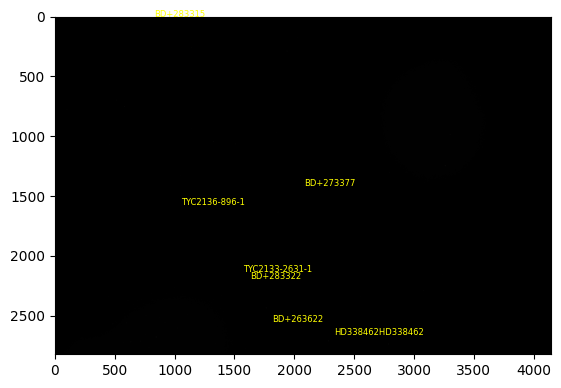

In [398]:
plt.imshow(img8, cmap='gray')
for idx, star in df_tgt[~df_tgt.starno.isnull()].iterrows():
    # print(star.starno, (star.cluster_cx, star.cluster_cy))
    plt.annotate(df_ref.loc[star.starno].id, (star.cluster_cx, star.cluster_cy), fontsize=6, color='yellow')

## Calculate transformation matrix
From known star mapping to image, compute affine transformation to map database projection to image

In [399]:
img_stars = df_tgt[~df_tgt.starno.isnull()][['starno','cluster_cx', 'cluster_cy', 'votes']]
img_ref_stars = df_ref[['id','cluster_cx', 'cluster_cy', 'ra', 'dec']].join(img_stars.set_index('starno'), rsuffix='r', how='right')
display(img_ref_stars)

,id,cluster_cx,cluster_cy,ra,dec,cluster_cxr,cluster_cyr,votes
starno,,,,,,,,
146,BD+273377,-0.029210,0.004259,291.016349,28.244277,2080.960870,1411.969565,0.999572
171,BD+283322,-0.026209,0.016299,291.200335,28.936620,1633.639344,2188.516393,0.998646
365,TYC2136-896-1,-0.030615,0.004161,290.925080,28.237399,1055.129310,1576.017241,0.999572
173,BD+283315,-0.030741,0.006317,290.914518,28.360776,826.606383,3.425532,0.999572
532,HD338462HD338462,0.000737,-0.031778,292.963559,26.192213,2329.276596,2657.244681,0.999323
214,TYC2133-2631-1,-0.002019,-0.029185,292.787450,26.340798,1573.500000,2132.500000,0.999323
709,BD+263622,0.025449,-0.022015,294.549464,26.742047,1813.444444,2553.444444,0.999054


In [400]:
matched_star_triple = img_ref_stars.sort_values('votes', ascending=False)[:3]
display(matched_star_triple)

,id,cluster_cx,cluster_cy,ra,dec,cluster_cxr,cluster_cyr,votes
starno,,,,,,,,
146,BD+273377,-0.029210,0.004259,291.016349,28.244277,2080.960870,1411.969565,0.999572
365,TYC2136-896-1,-0.030615,0.004161,290.925080,28.237399,1055.129310,1576.017241,0.999572
173,BD+283315,-0.030741,0.006317,290.914518,28.360776,826.606383,3.425532,0.999572


In [401]:
src = np.array([(row.cluster_cx, row.cluster_cy) for _, row in matched_star_triple.iterrows()], dtype=np.float32)
dst = np.array([(row.cluster_cxr, row.cluster_cyr) for _, row in matched_star_triple.iterrows()], dtype=np.float32)

In [402]:
import cv2
tx = cv2.getAffineTransform(src, dst)
print(tx)

[[ 734782.45586008  -62845.07009573   23811.66347298]
 [ -65811.19305509 -733380.22490324    2613.19536238]]


## Apply transform with dot-product

In [403]:
df_ref[['img_cx', 'img_cy']] = df_ref.apply(lambda r: pd.Series(np.dot(tx, [r.cluster_cx, r.cluster_cy, 1])).astype(np.int32), axis=1)

## Applyig transform with cv2.transform

In [404]:
# pts = np.array([[(r.cluster_cx, r.cluster_cy) for _,r in df_ref.iterrows()]], dtype=np.float32)
# print(pts[0,0,:])
# tx_pts = cv2.transform(pts, tx)
# print(tx_pts[0,0,:])
# print(pts.shape, tx_pts.shape)
# display(np.hstack([pts[0], tx_pts[0]])[0:5])

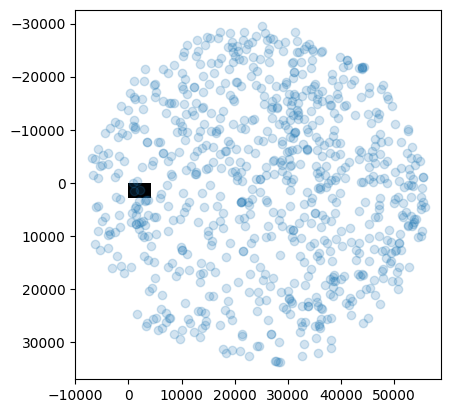

In [405]:
# pts = tx * pts
plt.imshow(img8, cmap='gray')
# plt.scatter(tx_pts[0, :, 0], tx_pts[0, :, 1], alpha=0.2)
plt.scatter(df_ref.img_cx, df_ref.img_cy, alpha=0.2)

# Reassign stars


In [406]:

def dist(x1,y1, x2,y2):
  return np.sqrt((y2-y1)**2+(x2-x1)**2)
def reassign(t):
  x = df_ref.apply(lambda r: pd.Series([dist(t.cluster_cx, t.cluster_cy, r.img_cx, r.img_cy)]), axis=1)[0]
  m = x.min()
  if m < 25:
    idx = x.argmin()
    return pd.Series([idx, df_ref.iloc[idx].ra, df_ref.iloc[idx].dec])
  else:
    return None, None, None
df_tgt[['starno', 'ra', 'dec']] = df_tgt.apply(reassign, axis=1)


In [407]:
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y,starno,votes,ra,dec
0,230,2080.960870,1411.969565,16.000977,15.000977,15.844343,17.157654,"[2063, 1396, 2098, 1427]",366228,5785,60.802441,68.597562,146.0,0.999572,291.016349,28.244277
1,122,1633.639344,2188.516393,11.000977,12.000977,12.546237,11.557913,"[1622, 2176, 1645, 2201]",567100,8891,53.078723,47.538285,NaN,0.998646,NaN,NaN
2,116,1055.129310,1576.017241,10.000977,10.000977,11.035679,11.168344,"[1044, 1565, 1067, 1588]",408448,6403,55.449497,54.945122,365.0,0.999572,290.925080,28.237399
3,94,826.606383,3.425532,11.000977,2.000977,-333.531165,12.076901,"[814, 0, 839, 12]",1243,26,213.617939,28.452669,173.0,0.999572,290.914518,28.360776
4,94,2329.276596,2657.244681,9.000977,9.000977,9.997101,9.994672,"[2319, 2647, 2340, 2668]",688486,10863,45.926763,44.612881,NaN,0.999323,NaN,NaN
5,80,1573.500000,2132.500000,8.000977,10.000977,10.587776,8.386346,"[1565, 2122, 1582, 2143]",552581,8759,44.964239,35.636383,NaN,0.999323,NaN,NaN
6,63,1813.444444,2553.444444,7.000977,7.000977,7.877617,7.978889,"[1805, 2545, 1822, 2562]",661421,10457,39.647387,40.148788,NaN,0.999054,NaN,NaN


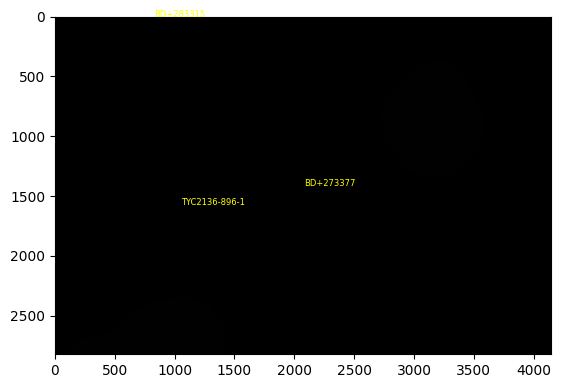

In [408]:
plt.imshow(img8, cmap='gray')
for idx, star in df_tgt[~df_tgt.starno.isnull()].iterrows():
    # print(star.starno, (star.cluster_cx, star.cluster_cy))
    plt.annotate(df_ref.loc[star.starno].id, (star.cluster_cx, star.cluster_cy), fontsize=6, color='yellow')

## Map pixel coordinated to RA,DEC
Use linear regression to fit a function to map pixel coordinates to RA,DEC.
Useful to find RA, DEC of image center.

In [409]:
from sklearn.linear_model import LinearRegression

nonantgt = df_tgt[ (~df_tgt.ra.isna()) & (~df_tgt.dec.isna())]
X = nonantgt[['cluster_cx', 'cluster_cy']]
y = nonantgt[['ra', 'dec']]
reg = LinearRegression().fit(X, y)
pred_center = reg.predict([[img8.shape[1]//2, img8.shape[0]//2]])[0]
pred_center = SkyCoord(pred_center[0] * u.degree, pred_center[1] * u.degree, frame=ICRS)
print(f"Image Center RA,DEC: {pred_center}")
print(f"Separation from target: {center.separation(pred_center).arcminute}")

Image Center RA,DEC: <SkyCoord (ICRS): (ra, dec) in deg
    (291.01556621, 28.24440362)>
Separation from target: 101.5353784613464


c:\Users\anand\anaconda3\envs\astro\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [410]:
df_tgt['name'] = None
for idx, star in df_tgt[~df_tgt.starno.isnull()].iterrows():
  df_tgt.loc[idx, 'name'] = df_ref.loc[star.starno].id

In [411]:
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y,starno,votes,ra,dec,name
0,230,2080.960870,1411.969565,16.000977,15.000977,15.844343,17.157654,"[2063, 1396, 2098, 1427]",366228,5785,60.802441,68.597562,146.0,0.999572,291.016349,28.244277,BD+273377
1,122,1633.639344,2188.516393,11.000977,12.000977,12.546237,11.557913,"[1622, 2176, 1645, 2201]",567100,8891,53.078723,47.538285,NaN,0.998646,NaN,NaN,None
2,116,1055.129310,1576.017241,10.000977,10.000977,11.035679,11.168344,"[1044, 1565, 1067, 1588]",408448,6403,55.449497,54.945122,365.0,0.999572,290.925080,28.237399,TYC2136-896-1
3,94,826.606383,3.425532,11.000977,2.000977,-333.531165,12.076901,"[814, 0, 839, 12]",1243,26,213.617939,28.452669,173.0,0.999572,290.914518,28.360776,BD+283315
4,94,2329.276596,2657.244681,9.000977,9.000977,9.997101,9.994672,"[2319, 2647, 2340, 2668]",688486,10863,45.926763,44.612881,NaN,0.999323,NaN,NaN,None
5,80,1573.500000,2132.500000,8.000977,10.000977,10.587776,8.386346,"[1565, 2122, 1582, 2143]",552581,8759,44.964239,35.636383,NaN,0.999323,NaN,NaN,None
6,63,1813.444444,2553.444444,7.000977,7.000977,7.877617,7.978889,"[1805, 2545, 1822, 2562]",661421,10457,39.647387,40.148788,NaN,0.999054,NaN,NaN,None
